In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark-nlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()
# Check the SparkSession
spark

In [58]:
sc = spark.sparkContext
data = sc.wholeTextFiles("s3://zihe-public/articles/AA/wiki_00")

In [59]:
import re
def get_id(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[1]

def get_title(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[3]

def get_content(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>\\n(.*?)\\n{2}"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    idx = matches.end(0)
    return x[idx:]

In [60]:
pages = data.flatMap(lambda x: (x[1].split('</doc>'))).map(lambda x : (get_id(x), get_title(x), get_content(x)))

In [61]:
pages = pages.toDF(["id","title","text"])

In [66]:
target_articles = ["Anthropology", "Altruism", "Autism", "Ayn Rand"]

In [67]:
sim_articles = pages.filter(pages['title'].isin(target_articles))

In [68]:
sim_articles.show()

+---+------------+--------------------+
| id|       title|                text|
+---+------------+--------------------+
| 25|      Autism|Autism is a devel...|
|336|    Altruism|Altruism is the p...|
|339|    Ayn Rand|Ayn Rand (; born ...|
|569|Anthropology|Anthropology is t...|
+---+------------+--------------------+



In [72]:
import nltk
# get the list of stopwords from nltk
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.append('xxxx')
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer, 
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary.
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [73]:
# transform text with the pipeline
cleaned = pipeline.fit(sim_articles).transform(sim_articles)

## WordCloud

In [76]:
text_all = " ".join([" ".join(c['finished_clean_lemma']) for c in cleaned.select("finished_clean_lemma").collect()])

In [86]:
for atc in target_articles:
    for i in atc.split(" "):
        text_all = text_all.replace(i.lower(), "")

keyword = "human behavior"
for i in keyword.split(" "):
    text_all = text_all.replace(i.lower(), "")

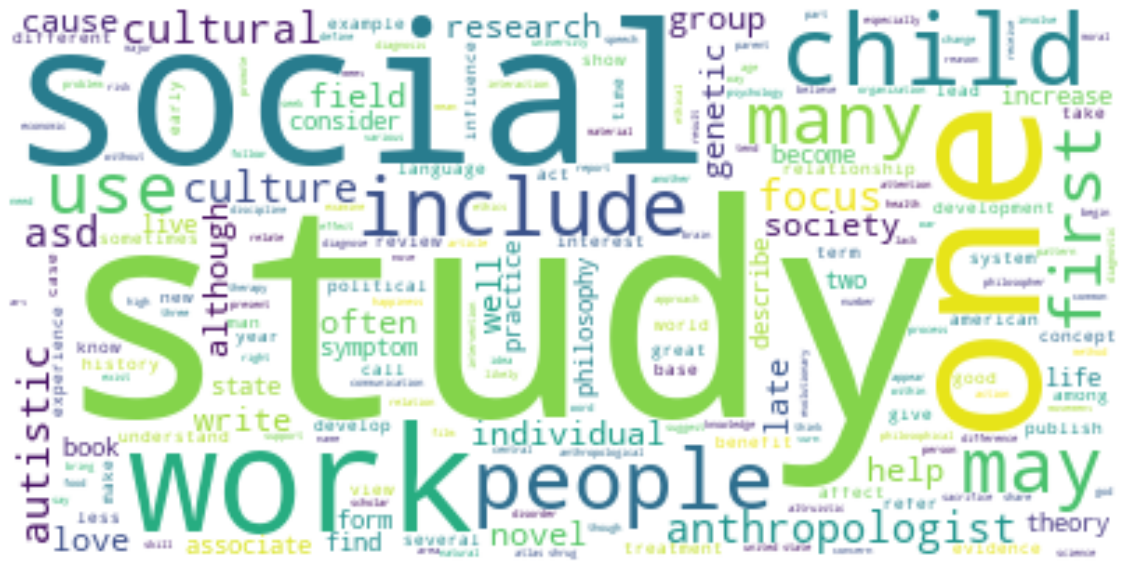

In [87]:
#pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
#% matplotlib inline

wordcloud_spam = WordCloud(background_color="white").generate(text_all)

# Lines 2 - 5
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

## Summary

In [89]:
cleaned.show(2)

+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|   title|                text|            document|               token|          normalized|               lemma|         clean_lemma|finished_clean_lemma|
+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 25|  Autism|Autism is a devel...|[[document, 0, 43...|[[token, 0, 5, Au...|[[token, 0, 5, au...|[[token, 0, 5, au...|[[token, 0, 5, au...|[autism, developm...|
|336|Altruism|Altruism is the p...|[[document, 0, 32...|[[token, 0, 7, Al...|[[token, 0, 7, al...|[[token, 0, 7, al...|[[token, 0, 7, al...|[altruism, princi...|
+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [90]:
sim_articles.show(2)

+---+--------+--------------------+
| id|   title|                text|
+---+--------+--------------------+
| 25|  Autism|Autism is a devel...|
|336|Altruism|Altruism is the p...|
+---+--------+--------------------+
only showing top 2 rows



In [93]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [99]:
def get_summary(title):
    article = sim_articles.filter(sim_articles['title'] == title)
    # transform text with the pipeline
    cleaned = pipeline.fit(article).transform(article)
    # expand the "finished_clean_lemma" column so that the words are not in a list
    from pyspark.sql.functions import explode, col
    cleaned_words = cleaned.withColumn("exploded_text", explode(col("finished_clean_lemma")))
    counts = cleaned_words.groupby('exploded_text').count()
    counts_pd = counts.toPandas()
    # counts_pd.sort_values(by=['count'], ascending=False)
    counts_dic = {counts_pd.loc[i, 'exploded_text']: counts_pd.loc[i, 'count'] for i in range(counts_pd.shape[0])}
    maximum_frequncy = max(counts_dic.values())
    for word in counts_dic.keys():
        counts_dic[word] = counts_dic[word]/maximum_frequncy
    text = article.collect()[0].asDict()['text']
    
   

    sentence_scores = {}
    for sent in re.split('\n |\. |\.\s',text):
        for word in nltk.word_tokenize(sent.lower()):
            if word in counts_dic.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = counts_dic[word]
                else:
                    sentence_scores[sent] += counts_dic[word]

    import heapq
    summary_sentences = heapq.nlargest(5, sentence_scores, key=sentence_scores.get)
    summary = '.\n\n'.join([i.replace("\n", "") for i in summary_sentences])
    print(summary)
    
    
for title in target_articles:
    print(title)
    get_summary(title)
    print("\n")


Anthropology
In the United States, anthropology has traditionally been divided into the four field approach developed by Franz Boas in the early 20th century: "biological" or "physical" anthropology; "social", "cultural", or "sociocultural" anthropology; and archaeology; plus anthropological linguistics.

In summary, while we stress that constructive engagement between anthropology and the military is possible, CEAUSSIC suggests that the AAA emphasize the incompatibility of HTS with disciplinary ethics and practice for job seekers and that it further recognize the problem of allowing HTS to define the meaning of "anthropology" within DoD."Before WWII British 'social anthropology' and American 'cultural anthropology' were still distinct traditions.

Anthropology builds upon knowledge from natural sciences, including the discoveries about the origin and evolution of "Homo sapiens", human physical traits, human behavior, the variations among different groups of humans, how the evolutionar